# Problem 20: Key sentences (10 points)

_Version 1.1_

In this notebook, you'll implement a procedure that attempts to summarize a long document by identifying and ranking important sentences _automatically_. It exercises your understanding of the singular value decomposition (SVD), Numpy, and some basic Python string manipulation. It is worth ten (10) points in total. While the exercises build on one another conceptually, we have precomputed solutions you'll need in each instance so that you can complete them in any order, similar to the Midterm 2 problems.

* Exercise 0: 2 points
* Exercise 1: 2 points
* Exercise 2: 3 points
* Exercise 3: 2 points
* Exercise 4: 1 point

> **Note 0.** Exercises 0-2 are "pure coding" exercises. To solve Exercises 3 and 4, you'll need a little bit of math.
>
> **Note 1.** When you submit to the autograder, there will be a strict 60-second time limit to execute your notebook. So if you notice your codes are taking much longer than that to run, reconsider your approach! Our reference solutions complete in less than 10 seconds.

**Pro-tips.**
- If your program behavior seem strange, try resetting the kernel and rerunning everything.
- If you mess up this notebook or just want to start from scratch, save copies of all your partial responses and use `Actions` $\rightarrow$ `Reset Assignment` to get a fresh, original copy of this notebook. (_Resetting will wipe out any answers you've written so far, so be sure to stash those somewhere safe if you intend to keep or reuse them!_)
- If you generate excessive output (e.g., from a ill-placed `print` statement), causing the notebook to load slowly or not at all, use `Actions` $\rightarrow$ `Clear Notebook Output` to get a clean copy. The clean copy will retain your code but remove any generated output. **However**, it will also **rename** the notebook to `clean.xxx.ipynb`. Since the autograder expects a notebook file with the original name, you'll need to rename the clean notebook accordingly.

**Revision history.**
* Version 1.1: Corrected some grammatical errors [Th Apr 23]
* Version 1.0: Initial release

## Setup ##

Run the following code cells, which will load the modules you'll need.

In [1]:
import sys
print("* Python version:", sys.version)

import pickle

from problem_utils import get_path

# The usual suspects
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("* Numpy version:", np.__version__)
print("* Scipy version:", sp.__version__)
print("* Matplotlib version:", matplotlib.__version__)

* Python version: 3.8.7 (default, Jan 25 2021, 11:14:52) 
[GCC 5.5.0 20171010]
* Numpy version: 1.22.1
* Scipy version: 1.7.3
* Matplotlib version: 3.5.1


## Background ##

Suppose you have a long report or document to read but limited time. Which sentences are the most important? In this notebook, you'll formulate the task of finding key sentences as a linear algebra problem, and see if such an automatic method can help.

**Idea.** Let's start with the following intuitive idea:

> A sentence is _important_ if it contains many important words. And a word is important if it appears in many important sentences.

At first glance, this idea seems a bit circular! But it turns out we can formulate it as a well-defined mathematical problem in the language of linear algebra.

**Data representation.** Suppose the document consists of $n$ distinct sentences and $m$ _unique_ words. Next, let $i$ be a word and let $j$ be a sentence. Furthermore, let $n_i$ denote the number of sentences containing word $i$. We can represent the document by a matrix $A$, called the _term-sentence matrix_, where each entry $a_{i,j}$ is defined as

$$
  a_{i,j} = \left\{ \begin{array}{cl}
          \dfrac{1}{\ln \left( \frac{n+1}{n_i} \right)} & \mbox{if word $i$ appears in sentence $j$, or} \\
          0                                             & \mbox{otherwise.}
      \end{array} \right.
$$

Here, $\ln x$ denotes the natural logarithm of $x$. Observe that $a_{i,j}$ tends to be small if $i$ does not appear in many sentences (i.e., $n_i$ is small). The $n+1$ ensures that we do not divide by zero when calculating $a_{i,j}$; in particular, even if word $i$ appears in every sentence ($n_i = n$), the value $\ln \frac{n+1}{n_i} > 0$. Lastly, you'd expect each sentence to contain just a few of the possible words. Therefore, you might expect $A$ to be sparse. 

**A mathematical formulation of the task.** Given word $i$ and sentence $j$, let's denote word $i$'s _importance score_ by $w_i$, and let $s_j$ denote the importance score of sentence $j$. These scores are just numbers on an arbitrary scale, but let's take them to be non-negative ($w_i, s_j \geq 0$).

We said we think these scores are inter-related. Suppose we believe these relationships are _linear_. Then we might model their relationships by

$$\begin{eqnarray}
w_i & \, \propto \, & \sum_j a_{i,j} \, s_j \\
s_j & \, \propto \, & \sum_i a_{j,i} \, w_i,
\end{eqnarray}$$

where the $\propto$ symbol means _proportional to_. So, the first formula says that if word $i$ appears in sentence $j$, meaning $a_{i,j} \neq 0$, then $i$'s score, $w_i$, increases in proportion to $j$'s score, $s_j$. The second formula is interpreted analogously.

**If we know $w_i$ and $s_j$ for every word $i$ and every sentence $j$, then the most important words and sentences should have the largest scores.** Thus, similar to the webpage ranking problem of Notebook 11, we can use these scores to rank words or sentences.

Right away, you should recognize these two formulae can be rewritten in matrix form. Letting $w = [ w_0, w_1, \ldots, w_{m-1} ]$ be the (column) vector of word scores and $s = [s_0, s_1, \ldots, s_{n-1}]$ be the (column) vector of sentence scores, we can define $w$ and $s$ as

$$\begin{eqnarray}
c_w \, w & = & A \, s \\
c_s \, s & = & A^T \, w,
\end{eqnarray}$$

where $c_w$ and $c_s$ are two _unknown_ constants. (They are unknown because we only said that scores have proportional relationships, so there may be an arbitrary scaling factor.)

Going one step further, let's plug these two equations into one another to obtain the following:

$$\begin{eqnarray}
  (A A^T) \, w & = & (c_s c_w) \, w \\
  (A^T A) \, s & = & (c_w c_s) \, s.
\end{eqnarray}$$

That should look familiar: it's an eigenvalue problem! In particular, $c_s c_w$ is an eigenvalue of the $m \times m$ matrix $A A^T$, whose corresponding eigenvector is $w$. Similarly, $c_w c_s = c_s c_w$ is _also_ an eigenvalue of the $n \times n$ matrix $A^T A$, whose corresponding eigenvector is $s$.

Recall that every matrix has a singular value decomposition. Suppose we were to give you one of the singular values of $A$---call it $\sigma_0$ and suppose it is the largest one. Let's say we also give you the left and right singular vectors---call them, $u_0$ and $v_0$, respectively---for $\sigma_0$. From these, **you should be able to figure out how to obtain $w$ and $s$ from $u_0$ and/or $v_0$.** _(Notebook 15, anyone?)_

> Aside: Recall that the singular values are always non-negative. Furthermore, since the entries of $A$ are also non-negative, if $\sigma_0$ is the largest singular value, then it turns out that $u_0$ and $v_0$ are also non-negative. You'll need this fact later.

**An algorithm.** From the background above, we now have a "simple" algorithm to rank words and sentences.

1. Given a document, construct the word-sentence matrix $A$.
2. Compute the **largest** (or **principal**) singular value and corresponding singular vectors of $A$. Denote the singular value by $\sigma_0$ and the left- and right-singular vectors as $u_0$ and $v_0$, respectively.
3. Use $u_0$ and $v_0$ to rank words and sentences. (**You** need to figure out the relationship between $w$ and $s$ and $u_0$ and $v_0$!)

## Exercises ##

In the exercises below, there are two major steps. First, you need to write some code to clean a document and construct a _sparse_ term-sentence matrix. These are Exercises 0-2. Then, you need to implement the scoring algorithm above (see "**An algorithm**"), which are Exercises 3 and 4.

**Sample data.** Let's use as our sample dataset [a recent article from the New York Times](https://www.nytimes.com/2020/04/18/us/coronavirus-women-essential-workers.html). Here is some code to read the raw contents of this article from a text file, splitting it into a list of lines named `raw_doc`:

In [2]:
def read_doc(filepath):
    with open(filepath, 'rt', encoding='utf-8') as fp:
        doc = [line for line in fp.read().splitlines() if line.strip() != '']
    return doc

# Read sample file:
raw_doc = read_doc(get_path('nyt2.txt'))
    
print("=== Here are the first 7 lines of the sample document ===")
for k, line in enumerate(raw_doc[:7]):
    print(f"\n* raw_doc[{k}] == {repr(line)}")
print("\n... (and so on) ...")

=== Here are the first 7 lines of the sample document ===

* raw_doc[0] == 'How Millions of Women Became the Most Essential Workers in America By Campbell Robertson and Robert Gebeloff April 18, 2020 '

* raw_doc[1] == 'Every day, Constance Warren stands behind the cold cuts counter at a grocery store in New Orleans, watching the regular customers come and go. '

* raw_doc[2] == 'They thank Ms Warren and tell her they do not like being stuck indoors, waiting out the epidemic. She wraps their honey-smoked turkey and smiles. '

* raw_doc[3] == 'It is good to have a job right now, the mixed fortune of being deemed an essential worker. But she wonders whether, once everyday life is safe again, people will remember the role she played when it was not. '

* raw_doc[4] == '"Don\'t forget that we were open to serve you in your time of need," she said on a break one recent workday afternoon. "You never know when you might need us again." '

* raw_doc[5] == 'From the cashier to the emergency roo

### Exercise 0: Extracting sentences (2 points) ###

Recall that each element of `raw_doc` is one line from a file. Each line may contain more than one sentence. For example, `raw_doc[4]` above has two sentences. We want to separate these.

Implement the function, `get_sentences(doc)`, below, so that it does so. It should take as input a variable `doc`, which is a list of lines just like `raw_doc` above. It should then return a list of sentences, following this procedure:

- Take the lines as-is. That is, do not rejoin the lines; just process them one at a time and assume that a single sentence never crosses between two lines.
- Separate each line into sentences. Assume that the following characters delimit sentences: periods (`'.'`), question marks (`'?'`), and exclamation points (`'!'`). These delimiters should be **omitted** from the returned sentences, too.
- Remove any leading or trailing spaces in each sentence.
- If, after the above, a sentence is blank (the empty string, `''`), that sentence should be omitted.
- Return the list of sentences. The sentences must be in the same order that they appear in the file.

> **Hint.** The `re` module includes a helpful function named [`re.split()`](https://docs.python.org/3/library/re.html#re.split).

The next code cell has an example of the expected input and output.

In [3]:
ex0_demo_input = ["  This is a phrase; this, too, is a phrase. But this is another sentence.",
                  "Hark!",
                  "    ",
                  "Come what may    <-- save those spaces, but not these -->    ",
                  "What did you say?Split into 3 (even without a space)? Okie dokie."]

ex0_demo_output = ["This is a phrase; this, too, is a phrase",
                   "But this is another sentence",
                   "Hark",
                   "Come what may    <-- save those spaces, but not these -->",
                   "What did you say",
                   "Split into 3 (even without a space)",
                   "Okie dokie"]

In [4]:
import re # Maybe re.split() will help?

# Complete this function:
def get_sentences(doc):
    assert isinstance(doc, list)
    
    sentences = []
    
    for line in doc:
        cleaned_sentence = [sentence.strip() for sentence in re.split('[.?!]', line) if sentence.strip()]
        
        sentences.extend(cleaned_sentence)
        
    return sentences
  
# sentences = []
#     for line in doc:
#         line_sentences = [s.strip() for s in re.split('[.?!]', line)]
#         sentences += [s for s in line_sentences if s != '']
#     return sentences

# Demo:
get_sentences(ex0_demo_input)

['This is a phrase; this, too, is a phrase',
 'But this is another sentence',
 'Hark',
 'Come what may    <-- save those spaces, but not these -->',
 'What did you say',
 'Split into 3 (even without a space)',
 'Okie dokie']

In [5]:
# Test cell: `ex0__get_sentences` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

# Random tests
from problem_utils import ex0_check_one
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex0_check_one(get_sentences)

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


### Precomputed solution for Exercise 0 ###

Here is code that loads a precomputed set of sentences for the input document. Regardless of whether your Exercise 0 works or not, please run this cell now so subsequent exercises can continue. It will define a variable named **`raw_sents`**. Subsequent code needs it, so do not modify it!

In [6]:
with open(get_path('ex0_soln.txt'), 'rt') as fp:
    raw_sents = [s.strip() for s in fp.readlines()]
    
print("=== First few sentences ===")
for k, s in enumerate(raw_sents[:10]):
    print(f"raw_sents[{k}] == {repr(s)}")

=== First few sentences ===
raw_sents[0] == 'How Millions of Women Became the Most Essential Workers in America By Campbell Robertson and Robert Gebeloff April 18, 2020'
raw_sents[1] == 'Every day, Constance Warren stands behind the cold cuts counter at a grocery store in New Orleans, watching the regular customers come and go'
raw_sents[2] == 'They thank Ms Warren and tell her they do not like being stuck indoors, waiting out the epidemic'
raw_sents[3] == 'She wraps their honey-smoked turkey and smiles'
raw_sents[4] == 'It is good to have a job right now, the mixed fortune of being deemed an essential worker'
raw_sents[5] == 'But she wonders whether, once everyday life is safe again, people will remember the role she played when it was not'
raw_sents[6] == '"Don\'t forget that we were open to serve you in your time of need," she said on a break one recent workday afternoon'
raw_sents[7] == '"You never know when you might need us again'
raw_sents[8] == '"'
raw_sents[9] == 'From the cas

### Stopwords ###

Recall that a common text-preprocessing step is to remove _stopwords_. These are words that occur frequently but do not carry substantive meaning.

We have determined a collection of stopwords for you. The following code cell creates a **Python set** called `STOPWORDS` containing them. Later, you will filter these words from sentences. Run this cell now.

In [7]:
from problem_utils import STOPWORDS
print(f"There are {len(STOPWORDS)} stopwords. Examples:")

for w in ["ourselves", "you're", "needn't", "cat", "dog", "python"]:
    is_or_isnt = "is" if w in STOPWORDS else "is *not*"
    print(f"- {repr(w)} {is_or_isnt} a stopword.")

There are 179 stopwords. Examples:
- 'ourselves' is a stopword.
- "you're" is a stopword.
- "needn't" is a stopword.
- 'cat' is *not* a stopword.
- 'dog' is *not* a stopword.
- 'python' is *not* a stopword.


### Sentence cleaning ###

Recall from Midterm 1 that you developed a method to clean a sentence, breaking it up into a set of normalized words where single-quotes embedded within a word (e.g., `"don't"`, `"you're"`) are preserved. Here was the sample solution to that problem, which you will need again.

In [8]:
def clean(s):
    from re import finditer
    pattern = r"[a-z]+('[a-z])?[a-z]*"
    return [match.group(0) for match in finditer(pattern, s.lower())]

print("* Sentence #6 ==", repr(raw_sents[6]))
print("\n* clean(raw_sents[6]) ==", clean(raw_sents[6]))

* Sentence #6 == '"Don\'t forget that we were open to serve you in your time of need," she said on a break one recent workday afternoon'

* clean(raw_sents[6]) == ["don't", 'forget', 'that', 'we', 'were', 'open', 'to', 'serve', 'you', 'in', 'your', 'time', 'of', 'need', 'she', 'said', 'on', 'a', 'break', 'one', 'recent', 'workday', 'afternoon']


### Exercise 1: Construct bags of words (2 points) ###

Your next task is to construct the _bag-of-words representation_ of each sentence. If `s` is a sentence, its bag-of-words representation is a set (or "bag") of its unique words. However, this set should never include stopwords.

Complete the function `gen_bag_of_words(sents)` to perform this task. In particular, the input `sents` is a list of sentences, as might be produced by Exercise 0. Your function should do the following:

- Split each sentence `sents[k]` into a list of words, using `clean()` defined above.
- Convert this list into a set, removing any stopwords.
- Return a list of these sets. If the returned list is named `bags`, then `bags[k]` should be the set for `sents[k]`.

The next code cell shows an example of the expected input and output of your function.

In [9]:
ex1_demo_input = ["This is a phrase; this, too, is a phrase",
                  "But this is another sentence",
                  "Hark",
                  "Come what may    <-- save those spaces, but not these -->",
                  "What did you say",
                  "Split into 3 (even without a space)",
                  "Okie dokie"]
ex1_demo_output = [{'phrase'},
                   {'another', 'sentence'},
                   {'hark'},
                   {'come', 'may', 'save', 'spaces'},
                   {'say'},
                   {'even', 'space', 'split', 'without'},
                   {'dokie', 'okie'}]

In [10]:
def gen_bag_of_words(sents):
    assert isinstance(sents, list)
    
    bags_list = []
    
    for sentence in sents:
        cleaned_sentence = clean(sentence)
        bags_set = set()
        for word in cleaned_sentence:
            if word not in STOPWORDS:
                bags_set.add(word)
    
        bags_list.append(bags_set)

    return bags_list

# def bag(s):
#         return set(clean(s)) - STOPWORDS
#     return [bag(s) for s in sents]

# Demo:
gen_bag_of_words(ex1_demo_input)

[{'phrase'},
 {'another', 'sentence'},
 {'hark'},
 {'come', 'may', 'save', 'spaces'},
 {'say'},
 {'even', 'space', 'split', 'without'},
 {'dokie', 'okie'}]

In [11]:
# Test cell: `ex1__gen_bag_of_words` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from problem_utils import ex1_check_one
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex1_check_one(gen_bag_of_words)

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


### Precomputed solution for Exercise 1 ###

Here is some code to load precomputed bags for the input document. Regardless of whether your Exercise 1 works or not, please run this cell now so subsequent exercises can continue. It will define a variable named **`bags`**. Subsequent code needs it, so do not modify it!

In [12]:
with open(get_path('ex1_soln.pickle'), 'rb') as fp:
    bags = pickle.load(fp)
    
print("=== First few bags ===")
for k, b in enumerate(bags[:10]):
    print(f"bags[{k}] == {repr(b)}")

=== First few bags ===
bags[0] == {'essential', 'gebeloff', 'workers', 'america', 'april', 'campbell', 'robertson', 'robert', 'women', 'millions', 'became'}
bags[1] == {'stands', 'orleans', 'day', 'grocery', 'behind', 'cold', 'new', 'cuts', 'constance', 'counter', 'come', 'store', 'watching', 'go', 'warren', 'every', 'customers', 'regular'}
bags[2] == {'tell', 'epidemic', 'stuck', 'like', 'waiting', 'indoors', 'warren', 'thank', 'ms'}
bags[3] == {'wraps', 'smoked', 'turkey', 'honey', 'smiles'}
bags[4] == {'essential', 'good', 'mixed', 'fortune', 'worker', 'job', 'deemed', 'right'}
bags[5] == {'played', 'wonders', 'safe', 'people', 'role', 'remember', 'life', 'everyday', 'whether'}
bags[6] == {'time', 'need', 'serve', 'open', 'afternoon', 'one', 'forget', 'recent', 'break', 'workday', 'said'}
bags[7] == {'need', 'never', 'might', 'know', 'us'}
bags[8] == set()
bags[9] == {'likely', 'woman', 'taking', 'bus', 'room', 'pharmacist', 'front', 'check', 'soldier', 'national', 'aide', 'health',

### Generating IDs ###

The next major step is to build the sparse matrix $A$ from the bag-of-words representation. To do so, we need to give every word and every sentence an ID.

For sentence IDs, let's use the index in `raw_sents`. That is, for sentence, `raw_sents[k]`, take its ID to be simply `k`. If there are `n` sentences, then `0 <= k < n`.

For word IDs, let's create a dictionary named `word_to_id` such that given a word, `w`, its ID is `word_to_id[w]`. Later, we will need the inverse mapping as well. So, the code cell below also computes `id_to_word`, which maps an ID `i` back to its word, `id_to_word[i]`. In other words, `word_to_id[id_to_word[i]] == i` and `id_to_word[word_to_id[w]] == w`. If there are `m` unique words, then `0 <= i < m`.

In [13]:
from random import choices

all_words = set()
for b in bags:
    all_words |= b
word_to_id = {w: k for k, w in enumerate(all_words)}
id_to_word = {k: w for k, w in enumerate(all_words)}

print(f"There are {len(all_words)} unique words.")
for w in choices(list(all_words), k=5):
    print("- ID for", repr(w), "==", word_to_id[w])
    assert id_to_word[word_to_id[w]] == w

There are 610 unique words.
- ID for 'degree' == 193
- ID for 'morning' == 350
- ID for 'women' == 328
- ID for 'health' == 17
- ID for 'food' == 503


### Exercise 2: Constructing the coordinates for a sparse matrix (3 points) ###

We need to build the sparse matrix $A$. Recall the following facts:

- If there are $m$ words and $n$ sentences, then $A$ is $m \times n$.
- Let $i$ be the ID of a word, where $0 \leq i < m$, and let $j$ the ID of a sentence, where $0 \leq j < n$.
- Let $n_i$ be the number of sentences containing word $i$.
- Each entry $a_{i,j}$ of $A$ is defined by the formula below (copied from before):

Recall that entry $a_{i,j}$ is defined as follows:
$$
  a_{i,j} = \left\{ \begin{array}{cl}
          \left(\ln \dfrac{n+1}{n_i}\right)^{-1} & \mbox{if word $i$ appears in sentence $j$} \\
                             0                   & \mbox{otherwise.}
      \end{array} \right.
$$

**Your task.** Complete the function `gen_coords(bags, word_to_id)`, below, so that it generates the coordinates and values of the sparse matrix. In particular, it should take these two inputs:

- `bags`, a Python list of bags (i.e., a list of word-sets);
- `word_to_id`, a Python dictionary mapping of each word `w` to its ID, which is `word_to_id[w]`.

It should create and return three Python **lists**, `rows`, `cols`, and `vals`, which store the _coordinate_ (COO) representation of the sparse matrix. That is, every triple `(rows[k], cols[k], vals[k])` indicates that a word, whose ID is `rows[k]`, appears in a sentence whose ID is `cols[k]`. Furthermore, let `rows[k]` $=i$ and `cols[k]` $=j$. Then `vals[k]` $=a_{i,j}$, as defined by the above formula.

> **Note 0.** To calculate the natural logarithm, you can use either Python's [built-in](https://docs.python.org/3/library/math.html#power-and-logarithmic-functions) or [Numpy's](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html).
>
> **Note 1.** Since it is a coordinate representation, the order of nonzeros in the output does not matter.

Here is an example of a simple input and expected output:

In [14]:
# Example inputs: (7 words) x (4 sentences)
ex2_demo_bags = [{'cat', 'dog', 'fish'},
                 {'red', 'blue'},
                 {'dog'},
                 {'one', 'two', 'dog', 'fish'}]
ex2_demo_w2id = {'cat': 0, 'dog': 1, 'fish': 2, 'red': 3, 'blue': 4, 'one': 5, 'two': 6}

from math import log   # log(x) == natural logarithm of x
ex2_rows = [       0,          1,          2,        3,        4,          1,        5,        6,          1,          2]
ex2_cols = [       0,          0,          0,        1,        1,          2,        3,        3,          3,          3]
ex2_vals = [1/log(5), 1/log(5/3), 1/log(2.5), 1/log(5), 1/log(5), 1/log(5/3), 1/log(5), 1/log(5), 1/log(5/3), 1/log(2.5)]

In [15]:
# Your task: Complete this function!
def gen_coords(bags, word_to_id):
    # Some code to help you get started:
    m, n = len(word_to_id), len(bags)
    rows, cols, vals = [], [], []
    
    # Count the number of sentences containing each word
    
    ni = np.zeros(m)
    
    for j in range(n):
        for w in bags[j]:
            ni[word_to_id[w]] += 1

    # Generate the sparse matrix coordinates and values
    
    for j in range(n):
        for w in bags[j]:
            i = word_to_id[w]
            aij = 1/(np.log((n + 1)/ni[i]))if ni[i] > 0 else 0
            rows.append(i)
            cols.append(j)
            vals.append(aij)
            
    return rows, cols, vals

# Runs your function on the demo:
gen_coords(ex2_demo_bags, ex2_demo_w2id)

([2, 1, 0, 3, 4, 1, 1, 6, 2, 5],
 [0, 0, 0, 1, 1, 2, 3, 3, 3, 3],
 [1.0913566679372915,
  1.9576151889712174,
  0.6213349345596119,
  0.6213349345596119,
  0.6213349345596119,
  1.9576151889712174,
  1.9576151889712174,
  0.6213349345596119,
  1.0913566679372915,
  0.6213349345596119])

In [16]:
# Test cell: `ex2__gen_matrix` (3 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from problem_utils import ex2_check_one
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex2_check_one(gen_coords)

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


### Precomputed solution for Exercise 2 ###

Here is some code to load precomputed coordinates for the input document. Regardless of whether your Exercise 2 works or not, please run this cell now so subsequent exercises can continue. It will define variables named **`rows`, `cols`, and `vals`**, which are the coordinate representation of the matrix. The subsequent code needs it, so do not modify it!

In [17]:
with open(get_path('ex2_soln.pickle'), 'rb') as fp:
    rows = pickle.load(fp)
    cols = pickle.load(fp)
    vals = pickle.load(fp)
    
print("=== First few coordinates ===")
print(f"* rows[:5] == {rows[:5]}")
print(f"* cols[:5] == {cols[:5]}")
print(f"* vals[:5] == {vals[:5]}")

=== First few coordinates ===
* rows[:5] == [291, 472, 162, 207, 334]
* cols[:5] == [0, 0, 0, 0, 0]
* vals[:5] == [0.49963027354508444, 0.21233540443616755, 0.49963027354508444, 0.21233540443616755, 0.21233540443616755]


### Calculating the SVD ###

Let's now create the sparse matrix and compute the SVD.

First, here is code to construct a sparse matrix $A$, using Scipy's compressed sparse row (CSR) storage. It stores $A$ in the variable named `A`, and visualizes its nonzero structure:

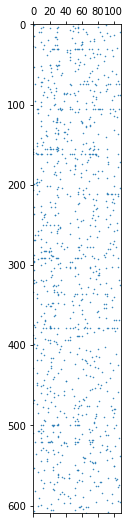

In [18]:
from scipy.sparse import csr_matrix
A = csr_matrix((vals, (rows, cols)), shape=(len(word_to_id), len(bags)))

plt.figure(figsize=(9, 9))
plt.spy(A, marker='.', markersize=1)
pass

Next, let's compute $\sigma_0$, the largest (or "principal") singular value of $A$, along with its left- and right-singular vectors, denoted as $u_0$ and $v_0$ (the "principal singular vectors"). Take note of the shape of the singular vectors:

In [19]:
def get_svds_largest(A):
    from scipy.sparse.linalg import svds
    from numpy import abs
    u, s, v = svds(A, k=1, which='LM', return_singular_vectors=True)
    return s, abs(u.reshape(A.shape[0])), abs(v.reshape(A.shape[1]))

sigma0, u0, v0 = get_svds_largest(A)
print("sigma_0 ==", sigma0)
print("u0.shape ==", u0.shape)
print("v0.shape ==", v0.shape)

sigma_0 == [3.49315864]
u0.shape == (610,)
v0.shape == (110,)


Here, we plot the entries of $u_0$ and $v_0$, which will be related to the rankings of the words and sentences. (Remember, **you** need to figure out how these might be related to the word and sentence ranking vectors, $w$ and $s$.)

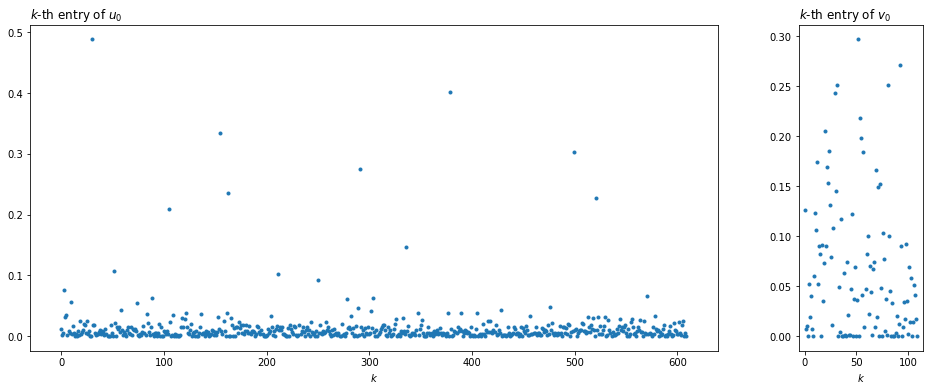

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [u0.shape[0], v0.shape[0]]})
ax0.plot(u0, '.')
ax0.set_title('$k$-th entry of $u_0$', loc='left')
ax0.set_xlabel('$k$')
ax1.plot(v0, '.')
ax1.set_title('$k$-th entry of $v_0$', loc='left')
ax1.set_xlabel('$k$')
pass

### Exercise 3: Ranking words (2 points) ###

Suppose you are given the principal left- and right-singular vectors, $u_0$ and $v_0$. Complete the function, `rank_words(u0, v0)`, so that it returns the **word IDs** in **descending order** of **word-importance score**.

The inputs `u0` and `v0` will be 1-D Numpy arrays. You should return a 1-D Numpy array **of integers**.

> If it's not immediately obvious what to do, go back to the description of the mathematical model and consider the shapes of the matrix and vector operands involved to see if you can figure it out. The setup of this problem **is** tricky, but the solution is simple.

In [25]:
def rank_words(u0, v0):
    
    from numpy import argsort
    
    return argsort(u0)[::-1]

In [26]:
# Demo on the input document:
word_ranking = rank_words(u0, v0)
top_ten_words = [id_to_word[k] for k in word_ranking[:10]]
print("Top 10 words:", top_ten_words)

Top 10 words: ['facing', 'set', 'mean', 'sold', 'even', 'husband', 'sectors', 'hospital', 'shift', 'technicians']


In [27]:
# Test cell: `ex3__rank_words` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from problem_utils import ex3_check_one
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex3_check_one(rank_words)

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


### Exercise 4: Ranking sentences (1 point) ###

Suppose you are given the principal left- and right-singular vectors, $u_0$ and $v_0$. Complete the function, `rank_sentences(u0, v0)`, so that it returns the **sentence IDs** in **descending order** of **sentence-importance score**.

The inputs `u0` and `v0` will be 1-D Numpy arrays. You should return a 1-D Numpy array **of integers**.

> If it's not immediately obvious what to do, go back to the description of the mathematical model and consider the shapes of the matrix and vector operands involved to see if you can figure it out.

In [28]:
def rank_sentences(u0, v0):
    
    from numpy import argsort
    
    return argsort(v0)[::-1]


In [29]:
# Demo:
sentence_ranking = rank_sentences(u0, v0)
top_five_sentences = [raw_sents[k] for k in sentence_ranking[:5]]
print("=== Top 5 sentences ===")
for k, s in enumerate(top_five_sentences):
    print(f"\n{k}.", repr(s))

=== Top 5 sentences ===

0. 'While women have steadily increased their share of high-end health care jobs like surgeons and other physicians, they have also been filling the unseen jobs proliferating on the lowest end of the wage scale, the workers who spend long and little-rewarded days bathing, feeding and medicating some of the most vulnerable people in the country'

1. 'Health care is harder physical work than people realize — workers in health care and social assistance suffer nonfatal injuries on the job at a rate higher than workers in construction or manufacturing'

2. 'That millions of care workers are "driven by incentives other than purely economic incentives" is in part why this work has traditionally been so undervalued, said Gabriel Winant, a labor historian at the University of Chicago'

3. 'This "care work force," said Mignon Duffy, a professor at the University of Massachusetts Lowell who studies women and labor, "is part of the infrastructure of our whole society'

4.

In [30]:
# Test cell: `ex4__rank_sentences` (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

from problem_utils import ex4_check_one
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex4_check_one(rank_sentences)

print("\n(Passed.)")

=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


**Fin!** You’ve reached the end of this part. Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. Good luck!

**Epilogue 0.** If you are interested in this method and others like it, see [_Matrix methods in data mining and pattern recognition_](https://epubs.siam.org/doi/book/10.1137/1.9780898718867) by Lars Eldén. Official Georgia Tech students can download chapters for free through the [GT library](https://epubs-siam-org.prx.library.gatech.edu/doi/book/10.1137/1.9780898718867).

**Epilogue 1.** It is an entertaining exercise to run this notebook on our course syllabus or the text of the _Whirlwind Tour of Python_ recommended textbook, and see if the results align with your experience.